# Auto Loan Default Prediction

In this project, we aim to predict whether a loan will default based on a variety of features such as the loan amount, asset cost, employment type, credit history, and more. By analyzing the dataset provided, we will use machine learning techniques to build a predictive model that can help lenders minimize risk and improve decision-making.

## Data Processing and EDA

### Import Libs

In [45]:
# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


### Load dataset

In [46]:
# Load the train and test datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Display the first few rows of the training dataset
train_data.head()

# Check for missing values and data types
print(train_data.isnull().sum())
print(train_data.dtypes)


UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

### Handle missing value and encode categorical var

In [47]:
# Define categorical and numeric columns
categorical_cols = ['EMPLOYMENT_TYPE']  # Add more categorical columns if needed
numeric_cols = ['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'PRIMARY_INSTAL_AMT', 'NO_OF_INQUIRIES']

# Handle missing values using SimpleImputer and scale the numeric columns using StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# One-hot encode categorical variables and fill missing values with 'Unknown'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformations to numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Separate the target variable from features
X = train_data.drop(['UNIQUEID', 'LOAN_DEFAULT'], axis=1)
y = train_data['LOAN_DEFAULT']


#### Feature Engineering --- derive Age

In [48]:
# Convert DATE_OF_BIRTH into Age
current_year = pd.Timestamp.now().year
train_data['DATE_OF_BIRTH'] = pd.to_datetime(train_data['DATE_OF_BIRTH'], format='%d-%m-%Y', errors='coerce')
train_data['AGE'] = current_year - train_data['DATE_OF_BIRTH'].dt.year

# Drop the DATE_OF_BIRTH column now that we have AGE
X['AGE'] = train_data['AGE']
X = X.drop(['DATE_OF_BIRTH'], axis=1)


## EDA

#### Distribution of target variables

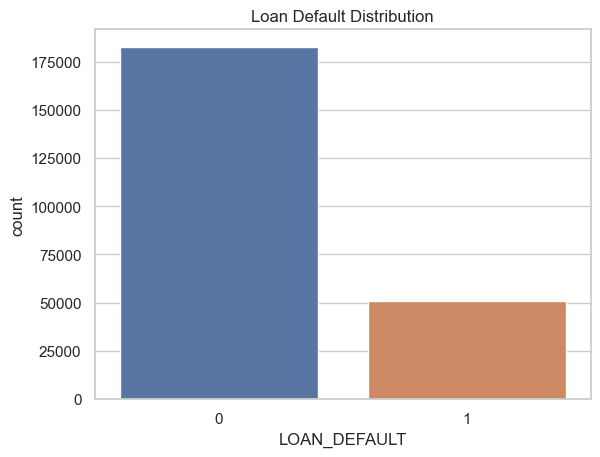

In [49]:
# Plot the distribution of the target variable (LOAN_DEFAULT)
sns.countplot(x='LOAN_DEFAULT', data=train_data)
plt.title('Loan Default Distribution')
plt.show()


### Correlation Heatmap

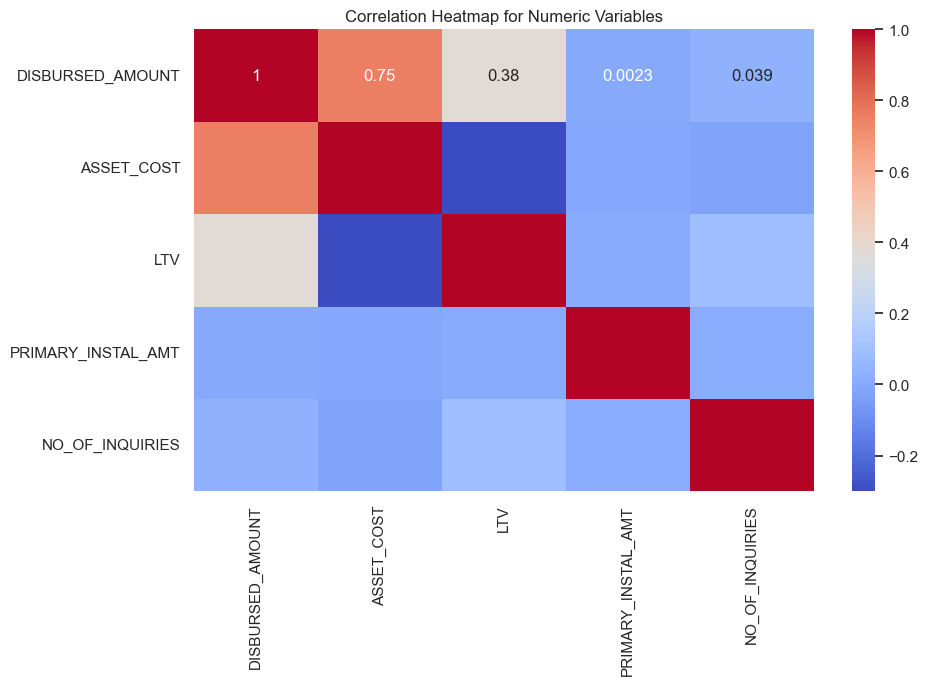

In [50]:
# Plot correlation heatmap for numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(train_data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Variables')
plt.show()



#### Distribution of Loan amount by default status

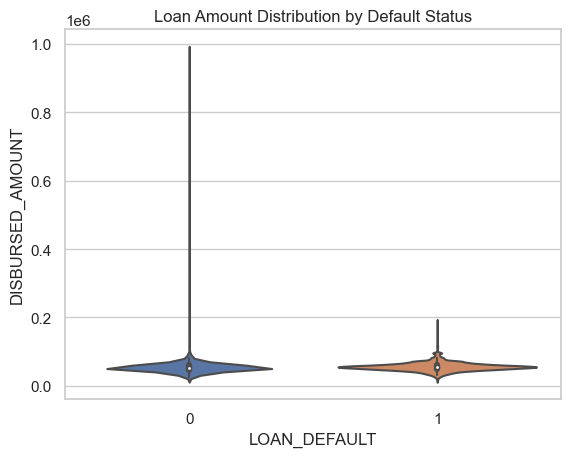

In [51]:
# Plot loan amount distribution by default status
sns.violinplot(x='LOAN_DEFAULT', y='DISBURSED_AMOUNT', data=train_data)
plt.title('Loan Amount Distribution by Default Status')
plt.show()


### Modeling

#### Define multiple models 

We are going to try Logistic Regression, Random Forest, and Gradient Boosting as our classification models.

In [52]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}


#### Cross-Validation for Model Comparison


In [53]:
# Perform cross-validation for each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Perform 5-fold cross-validation and compute mean accuracy
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"{model_name}: Mean cross-validated accuracy: {scores.mean():.4f}")


Logistic Regression: Mean cross-validated accuracy: 0.7828
Random Forest: Mean cross-validated accuracy: 0.7539
Gradient Boosting: Mean cross-validated accuracy: 0.7829


#### Grid Search for Hyperparameter Tuning

In [58]:
# Define parameter grids for Random Forest and Gradient Boosting
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 150],
        'classifier__max_depth': [10, 15],
        'classifier__min_samples_split': [2, 4]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 150],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 4]
    }
}

# Perform Grid Search for each model
for model_name in ['Random Forest', 'Gradient Boosting']:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models[model_name])])
    
    # Define Grid Search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    
    # Print the best hyperparameters and corresponding score
    print(f"{model_name}: Best parameters found: {grid_search.best_params_}")
    print(f"{model_name}: Best cross-validated accuracy: {grid_search.best_score_:.4f}")


Random Forest: Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 150}
Random Forest: Best cross-validated accuracy: 0.7829
Gradient Boosting: Best parameters found: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Gradient Boosting: Best cross-validated accuracy: 0.7829


#### Valuate Best Models on Test Set

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate best Random Forest and Gradient Boosting models on the test set
best_rf = grid_search.best_estimator_
best_gb = grid_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

# Evaluation metrics
def evaluate_model(y_test, y_pred):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))

print("Random Forest Test Set Performance:")
evaluate_model(y_test, y_pred_rf)

print("Gradient Boosting Test Set Performance:")
evaluate_model(y_test, y_pred_gb)


Random Forest Test Set Performance:
Accuracy: 0.7822478608650898
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Gradient Boosting Test Set Performance:
Accuracy: 0.7822478608650898
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


#### ROC-AUC Curve for Final Models

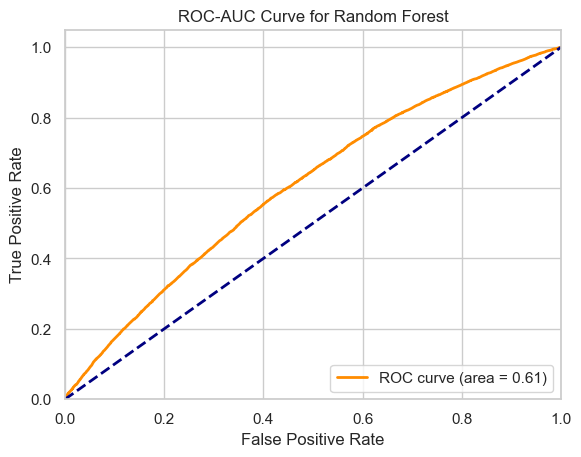

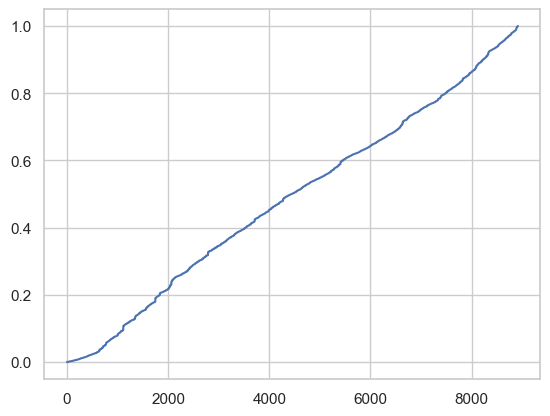

In [60]:
# ROC-AUC Curve for Random Forest
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

# ROC-AUC Curve for Gradient Boosting
y_pred_proba_gb = best_gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

plt.figure()
plt.plot(fpr_gb)
